# Прогнозирование заказов такси

Компания **«Чётенькое такси»** собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания. Значение метрики **RMSE** на тестовой выборке* должно быть **не больше 48**.

*тестовая выборка размером 10% от исходных данных.

**Содержание:**
1. [Подготовка данных](#section_1)
    1. [Чтение и знакомство с исходными данными.](#section_1A)
    2. [Работа с выбросами и ресемплирование](#section_1B)
2. [Анализ данных](#section_2)
    1. [Создание признаков](#section_2A)
3. [Обучение моделей](#section_3)
    1. [Валидация данных](#section_3A)
    2. [Масштабирование](#section_3B)
    3. [Базовая модель](#section_3C)
    4. [Линейная регрессия](#section_3D)
    5. [Случайный лес](#section_3E)
    6. [Градиентный бустинг](#section_3F)
4. [Тестирование](#section_4)
    1. [Итог](#section_4A)
5. [Чек-лист](#section_5)

<a id='section_1'></a>
## Подготовка данных

In [1]:
# импорт основных библиотек
import os
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt

# импорт спец. модули
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings("ignore")

# константы
RANDOM_STATE = 12345

# адреса расположения датасета
HOME_PATH = 'datasets/taxi.csv'
SERVER_PATH = '/datasets/taxi.csv'

<a id='section_1A'></a>
### Чтение и знакомство с данными

In [ ]:
# домашняя версия
if os.path.exists(HOME_PATH):
    df = pd.read_csv(HOME_PATH, parse_dates=['datetime'], index_col='datetime')
    print('Файл прочитан.')

# сетевая версия
elif os.path.exists(SERVER_PATH):
    df = pd.read_csv(SERVER_PATH, parse_dates=['datetime'], index_col='datetime')
    print('Файл прочитан.')

else:
    print('Не удалось прочесть файл. Возможно, был указан неверный путь.')


---< Исходный датасет >---


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32



---< Стат. информация >---


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


-----< Техническая информация >-----
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None 
Хронологический порядок соблюден: True



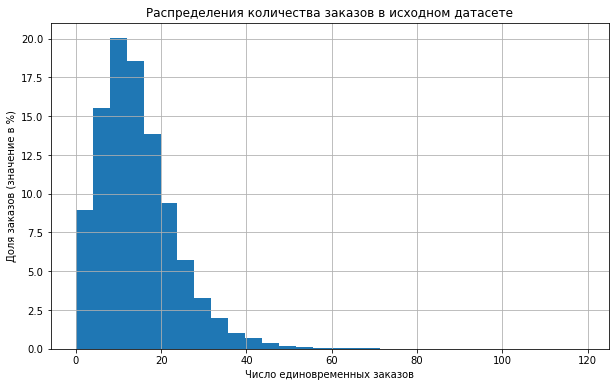

In [ ]:
# знакомство с данными
print('\n---< Исходный датасет >---')
display(df.head())

print('\n---< Стат. информация >---')
display(df.describe())

print('-----< Техническая информация >-----')
print(df.info(), f'\nХронологический порядок соблюден: {df.index.is_monotonic}\n')

df['num_orders'].hist(bins=30, figsize=(10, 6), weights=np.ones(len(df)) / len(df) * 100)
plt.title('Распределения количества заказов в исходном датасете')
plt.xlabel('Число единовременных заказов')
plt.ylabel('Доля заказов (значение в %)');

**Описание данных:**
- `datetime` - момент фиксации количества заказов (тип данных: `datetime64`);
- `num_orders` - количество заказов находится в столбце (целочисленный тип данных: `int64`).

Датасет содержит сведенья за 6 месяцев: **март-август 2018** года. Около **26 500 записей** о кол-ве заказов такси, фиксируемых каждый 10 минут. Пропуски в данных и дублирование дат - отсутствуют. Для каждого параметра установлен соответствующий тип данных. В датасете присутствуют выбросы.

___

<a id='section_1B'></a>
### Работа с выбросами и ресемплирование

На предыдущем графике легко заметить, что число единовременных заказов доходит до 120, при этом такие случаи - единичны. Обычно фиксируется не более 42 заказов каждые 10 минут. График распределения этих значений частично описывается _нормальным распределением_. Это помогает определить _границу_. Согласно "Правилу трёх σ" это ранее упомянутое число в 42 заказа, за пределами которого находятся выбросы около 1% данных.

Возможны три варианта устранение выбросов:
1. Сначала избавить исходные данные от эти объектов, а после выполнить необходимую процедуру ресемплинга, и продолжить работу.

2. Наоборот: Сначала выполнить ресемплинг, поскольку при объединении шести записей в одну происходит аппроксимация (усреднение). Завышенные значения могут быть компенсированы заниженными значениями, расположенных по соседству.

3. Поскольку выбросами являются объекты с повышенным числом заказов, то следует избавиться именно от той части заказов, которая "свыше обычной нормы". Заменить выбросы на максимальное значение, в пределах нормального распределения. Ведь, предыдущие вариантам удаляли сведенья о заказах целиком, оставляя пробел в хронологии, что не совсем верно, поскольку "базовый" поток заказав - присутствует.

4. Альтернативный вариант: замена на среднее значение.

In [ ]:
df_copy = df.copy()

# ресемплирование с выбросами
df_resample_outlier = df_copy.resample('1H').sum()
df_resample_outlier.columns = ['с выбросами']

# выявление и удаление выбросов
display(df_copy[df_copy['num_orders'] > 42])
print(f"Удалено {len(df_copy[df_copy['num_orders'] > 42])} объектов.")
df_copy = df_copy[df_copy['num_orders'] <= 42]

# ресемплирование без выбросов
df_resample = df_copy.resample('1H').sum()
df_resample.columns = ['без выбросов']

,num_orders
datetime,
2018-03-24 00:50:00,56
2018-04-23 00:50:00,45
2018-04-24 00:10:00,49
2018-04-24 00:20:00,58
2018-04-24 00:30:00,68
...,...
2018-08-31 09:40:00,48
2018-08-31 09:50:00,44
2018-08-31 17:50:00,44


Удалено 276 объектов.


,без выбросов,с выбросами
count,4416.000000,4416.000000
mean,81.193388,84.422781
std,38.316938,45.023853
min,0.000000,0.000000
25%,54.000000,54.000000
50%,78.000000,78.000000
75%,106.000000,107.000000
max,220.000000,462.000000


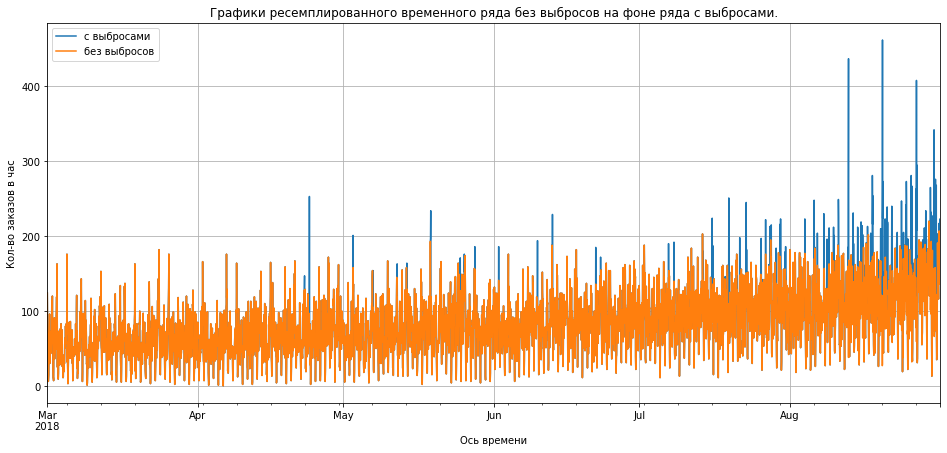

In [ ]:
# визуализация результата удаления выбросов
df_resample_outlier['с выбросами'].plot(figsize=(16, 7), legend=True, grid=True)
df_resample['без выбросов'].plot(figsize=(16, 7), legend=True, grid=True)
plt.title('Графики ресемплированного временного ряда без выбросов на фоне ряда с выбросами.')
plt.ylabel('Кол-во заказов в час')
plt.xlabel('Ось времени');

# сравнительная таблица статистических значений
display(df_resample.describe().join(df_resample_outlier.describe()))

In [ ]:
# выявление и удаление выбросов из ресемплированного датасета
num_orders_median = df_resample_outlier['с выбросами'].median()
num_orders_sigma  = df_resample_outlier['с выбросами'].std()
num_orders_newmax = num_orders_median + num_orders_sigma*3

outlier_index = df_resample_outlier[df_resample_outlier['с выбросами'] > num_orders_newmax].index
display(df_resample_outlier.loc[outlier_index].head())

df_resample_outlier.drop(outlier_index, inplace=True)
print(f"Удалено {len(outlier_index)} объектов.")

,с выбросами
datetime,
2018-04-24 00:00:00,253
2018-05-19 00:00:00,234
2018-06-13 02:00:00,229
2018-07-16 00:00:00,224
2018-07-19 10:00:00,251


Удалено 59 объектов.


,до ресемплирования,после ресемплирования
count,4416.000000,4357.000000
mean,81.193388,82.156300
std,38.316938,40.460942
min,0.000000,0.000000
25%,54.000000,54.000000
50%,78.000000,78.000000
75%,106.000000,106.000000
max,220.000000,213.000000


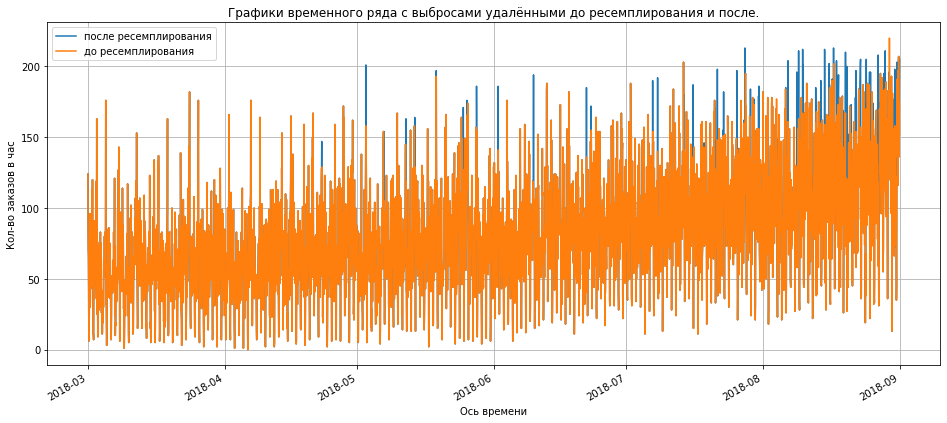

In [ ]:
# визуализация временного ряда с удалёнными выбросами на разных этапах
df_resample_outlier.columns = ['после ресемплирования']
df_resample_outlier['после ресемплирования'].plot(figsize=(16, 7), legend=True, grid=True)

df_resample.columns = ['до ресемплирования']
df_resample['до ресемплирования'].plot(figsize=(16, 7), legend=True, grid=True)
plt.title('Графики временного ряда с выбросами удалёнными до ресемплирования и после.')
plt.ylabel('Кол-во заказов в час')
plt.xlabel('Ось времени');

# сравнительная таблица статистических значений
display(df_resample.describe().join(df_resample_outlier.describe()))

Несмотря на то, что временные ряда получилось привести к схожему виду разными путями, между ними есть существенные отличия. Вариант №1 (удаление выбросов до ресемплирования):
- имеет меньшее стандартное отклонение σ,
- распределение более схожее с нормальным, т.к. медианное и среднее значения имеют не большую разницу,
- получившаяся выборка содержит больше объектов, чем при варианте №2.

,num_orders_change_on,num_orders_change_off
count,26496.000000,26496.000000
mean,13.969731,14.070463
std,8.763000,9.211330
min,0.000000,0.000000
25%,8.000000,8.000000
50%,13.000000,13.000000
75%,19.000000,19.000000
max,42.000000,119.000000


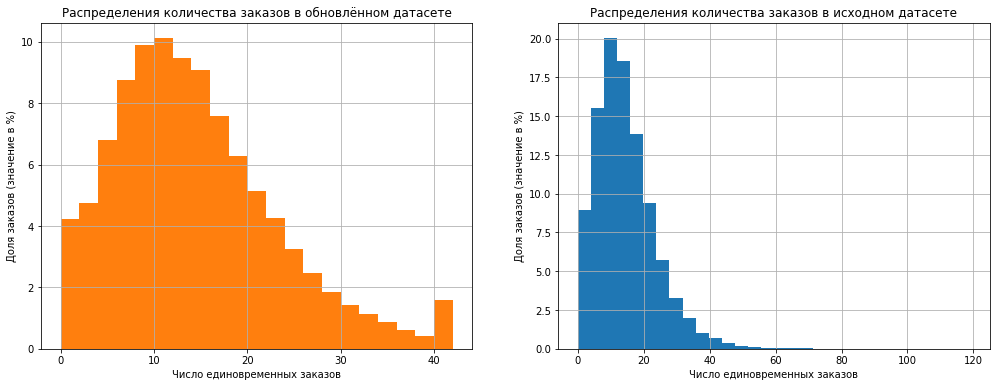

In [ ]:
# вариант №3 - замена выбросов на макс. значение

df_change_max = df.copy()
df_change_max.loc[df_change_max['num_orders'] > 42, 'num_orders'] = 42
display(df_change_max.describe().join(df.describe(), lsuffix='_change_on', rsuffix='_change_off'))

fig, axs = plt.subplots(1, 2, figsize=(17, 6))

axs[0].hist(df_change_max['num_orders'], bins=21, weights=np.ones(len(df)) / len(df) * 100, color='#FF7F0E')
axs[0].set_title('Распределения количества заказов в обновлённом датасете')
axs[0].set_ylabel('Доля заказов (значение в %)')
axs[0].set_xlabel('Число единовременных заказов')
axs[0].grid()

axs[1].hist(df['num_orders'], bins=30, weights=np.ones(len(df)) / len(df) * 100)
axs[1].set_title('Распределения количества заказов в исходном датасете')
axs[1].set_ylabel('Доля заказов (значение в %)')
axs[1].set_xlabel('Число единовременных заказов')
axs[1].grid()
plt.show()

,замена,удаление
count,4416.000000,4416.000000
mean,83.818388,81.193388
std,42.835323,38.316938
min,0.000000,0.000000
25%,54.000000,54.000000
50%,78.000000,78.000000
75%,107.000000,106.000000
max,248.000000,220.000000


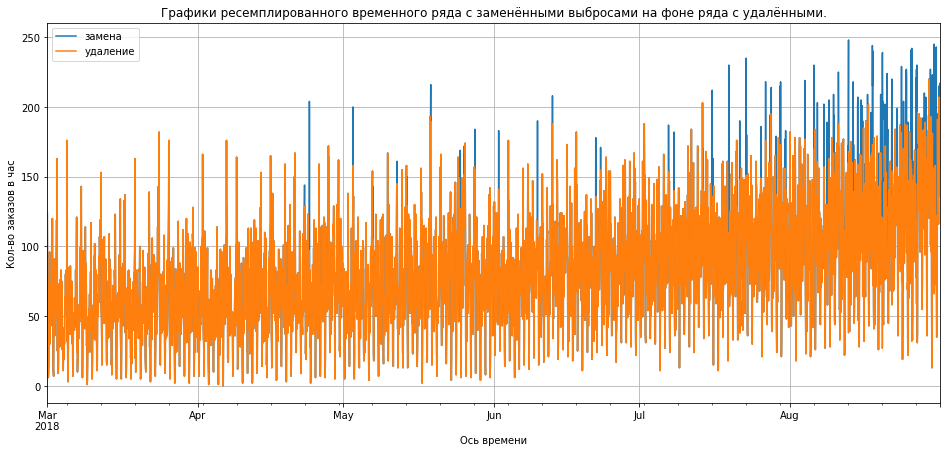

In [ ]:
# сравнение методов борьбы с выбросами: удаление и замена
df_change_max = df_change_max.resample('1H').sum()
df_change_max.columns = ['замена']
df_resample.columns = ['удаление']

# сравнительная таблица статистических значений
display(df_change_max.describe().join(df_resample.describe()))

# визуализация результатов
df_change_max['замена'].plot(figsize=(16, 7), legend=True, grid=True)
df_resample['удаление'].plot(figsize=(16, 7), legend=True, grid=True)
plt.title('Графики ресемплированного временного ряда с заменёнными выбросами на фоне ряда с удалёнными.')
plt.ylabel('Кол-во заказов в час')
plt.xlabel('Ось времени');

In [ ]:
# вариант 4 - замена выбросов на среднее значение
df_change_mean = df.copy()

for i in df[df['num_orders'] > 42].index:
    week_day = i.dayofweek
    minutes = i.minute
    hour = i.hour
    begin = i - pd.Timedelta(days = 7*2)
    end = i + pd.Timedelta(days = 7*2)
    near_time = df[begin:end]
    new_num_order = near_time[(near_time.index.dayofweek == week_day) &
                              (near_time.index.minute == minutes) &
                              (near_time.index.hour == hour)].mean()
    df_change_mean.loc[i] = new_num_order

,замена на максимум,замена на среднее
count,4416.000000,4416.000000
mean,83.818388,83.522392
std,42.835323,42.442319
min,0.000000,0.000000
25%,54.000000,54.000000
50%,78.000000,78.000000
75%,107.000000,107.000000
max,248.000000,404.333333


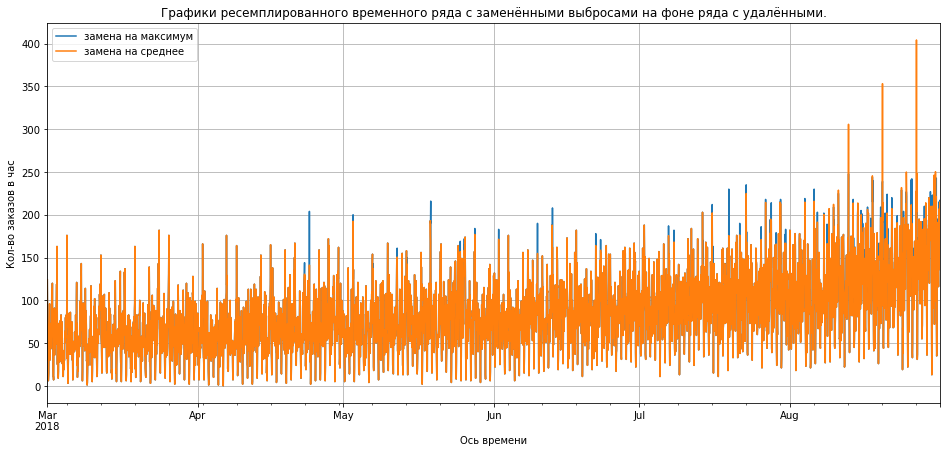

In [ ]:
# сравнение методов замены выбросов: максимум или среднее
df_change_mean = df_change_mean.resample('1H').sum()
df_change_mean.columns = ['замена на среднее']
df_change_max.columns = ['замена на максимум']

# сравнительная таблица статистических значений
display(df_change_max.describe().join(df_change_mean.describe()))

# визуализация результатов
df_change_max['замена на максимум'].plot(figsize=(16, 7), legend=True, grid=True)
df_change_mean['замена на среднее'].plot(figsize=(16, 7), legend=True, grid=True)
plt.title('Графики ресемплированного временного ряда с заменёнными выбросами на фоне ряда с удалёнными.')
plt.ylabel('Кол-во заказов в час')
plt.xlabel('Ось времени');

**Итог:** Временные ряды получились практически идентичным, за исключением стандартного отклонения, поскольку у выбросов были отсечены только "верхушки", и эти объекты остались с максимально высокими значениями, что отображает повышенный спрос на такси, но теперь в пределах нормального распределения.

В связи с вышесказанным, **далее**, в работе будет использоваться датасет с выбросами заменённые на максимум. Ресемплирование выполнено с шагов 1 час (_заданный горизонт прогнозирования_).

In [ ]:
# сохранение наилучшего результата
df = df_change_mean.copy()
df.columns = ['num_orders']

<a id='section_2'></a>
## Анализ данных

,num_orders
datetime,
2018-03-01 00:00:00,124.0
2018-03-01 01:00:00,85.0
2018-03-01 02:00:00,71.0
2018-03-01 03:00:00,66.0
2018-03-01 04:00:00,43.0


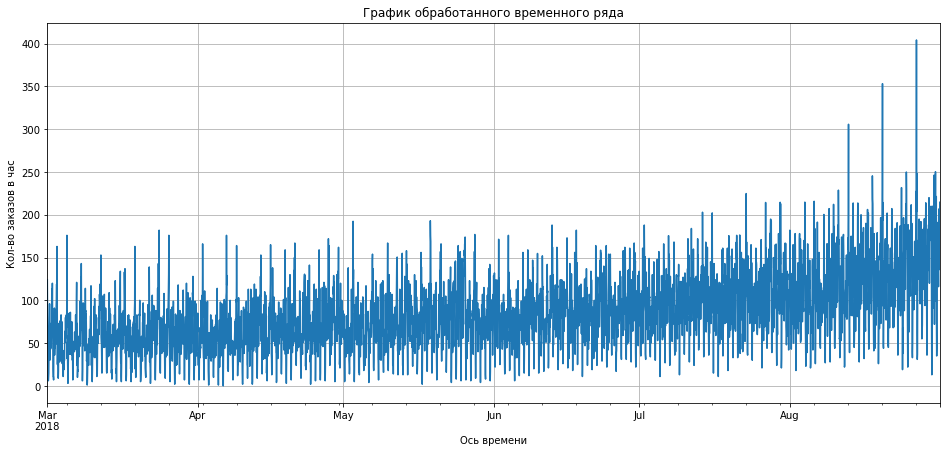

In [ ]:
# обновлённый вид данных
display(df.head())
df['num_orders'].plot(figsize=(16, 7), grid=True,
                      title='График обработанного временного ряда',
                      ylabel='Кол-во заказов в час',
                      xlabel='Ось времени');

Временной ряд насыщен объектами. Он не статичен: _среднее число заказов_ и _стандартное отклонение_ - увеличивается. Прослеживается **общая динамика роста** заказов, и должна присутствовать _сезонность_, поскольку в течение дня или недели количество заказов разнится. Далее будет разобран временной ряд отдельно по месяцам.

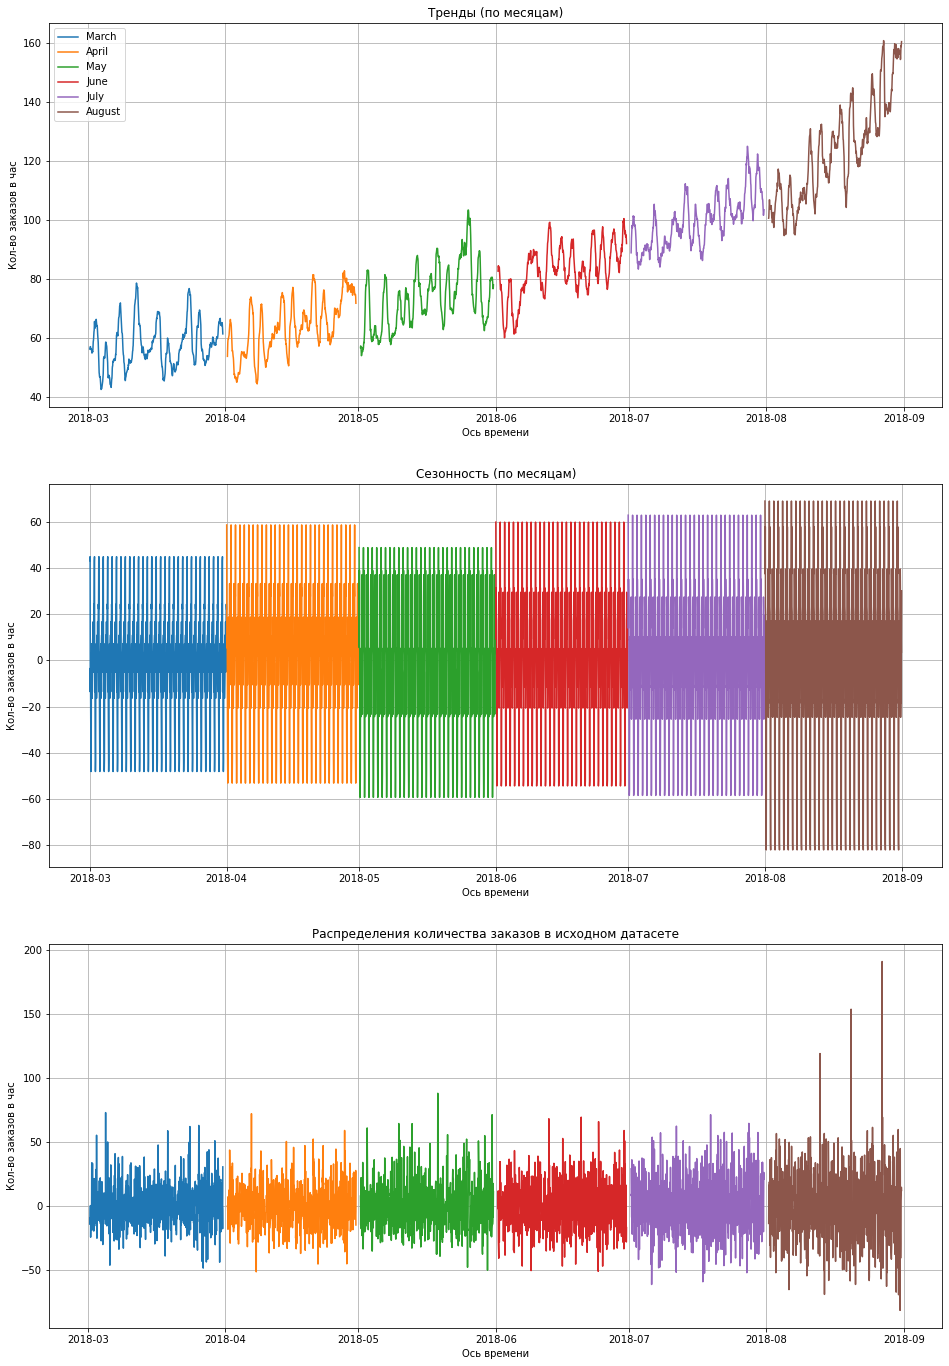

,March,April,May,June,July,August
count,744.000000,720.000000,744.000000,720.000000,744.000000,744.000000
mean,57.448656,63.626111,73.392204,82.966944,99.258065,123.782639
std,29.469931,31.327596,34.000082,32.124048,35.566606,49.270828
min,1.000000,0.000000,2.000000,6.000000,11.000000,13.000000
25%,39.000000,43.000000,53.000000,61.000000,76.000000,91.000000
50%,55.000000,61.000000,71.000000,83.000000,98.000000,122.000000
75%,75.000000,80.250000,92.000000,103.000000,122.000000,157.000000
max,182.000000,176.000000,193.000000,188.000000,224.800000,404.333333


In [ ]:
# выделение трендов, сезонностей, шума (по месяцам) и др. статистических значений
month_names = []
describe_table = pd.DataFrame(index=df.describe().index)
fig, axs = plt.subplots(3, 1, figsize=(16, 24))

for month in df.index.month.unique():
    describe_table = describe_table.join(df[df.index.month == month].describe(), rsuffix=month)
    name = df[df.index.month == month].index[0].strftime('%B')
    month_names.append(name)
    decomposed_month = seasonal_decompose(df[df.index.month == month])
    axs[0].plot(decomposed_month.trend.rename(name))
    axs[1].plot(decomposed_month.seasonal.rename(name))
    axs[2].plot(decomposed_month.resid.rename(name))

axs[0].set_title('Тренды (по месяцам)')
axs[0].set_ylabel('Кол-во заказов в час')
axs[0].set_xlabel('Ось времени')
axs[0].legend(month_names)
axs[0].grid()

axs[1].set_title('Сезонность (по месяцам)')
axs[1].set_ylabel('Кол-во заказов в час')
axs[1].set_xlabel('Ось времени')
axs[1].grid()

axs[2].set_title('Распределения количества заказов в исходном датасете')
axs[2].set_ylabel('Кол-во заказов в час')
axs[2].set_xlabel('Ось времени')
axs[2].grid()
plt.show()

describe_table.columns = month_names
display(describe_table)

**Тренды**, помимо пульсаций, имеют прослеживаемую закономерность: к концу месяца число заказов выше, чем в начале этого же месяца. Рост выглядит линейным.

**Сезонность*** имеет одинаковый интервал повторения, но каждый месяц имеет разный "размах" значений, а так же отличаются средним значением, отклонением и присутствием смещением:
- март, апрель и июль - симметричны;
- май, июнь - смещены в бóльшую сторону;
- август - смещён в меньшую сторону.

**Остаточная составляющая*** может продемонстрировать величину нетипичных заказов, которые могут возникать не предсказуемо.

*графики отображают не абсолютную величину заказов, а только их часть (трендовую, сезонную и остаточную). По этой причине графики могут иметь отрицательные значения. А так же могу быть расположенными симметрично относительно нуля, который на самом деле является средним значением за месяц.

_Примечание:_ Более точная информация собрана в виде таблицы со статистическими значениями, сразу после графиков.

Далее будет произведён разбор на составляющие одного месяца.

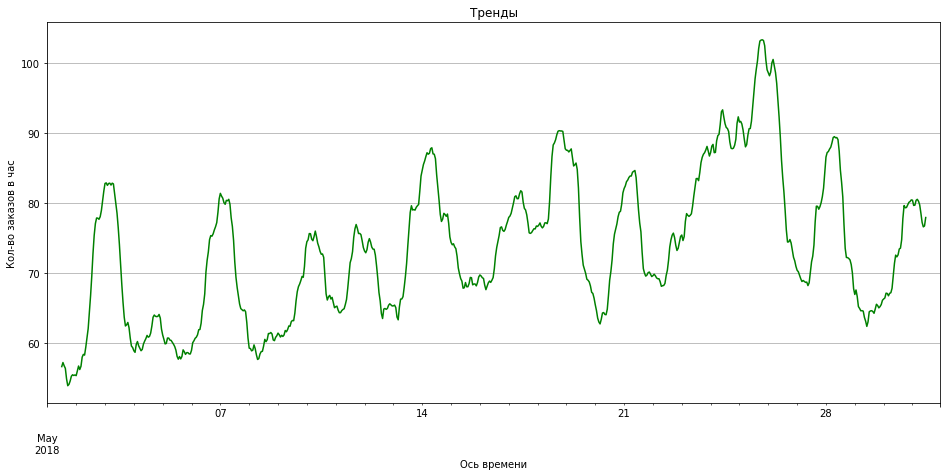

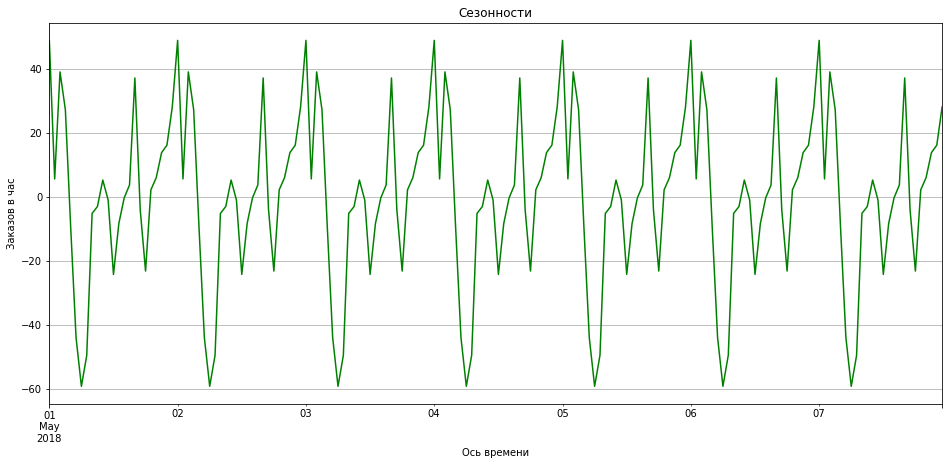

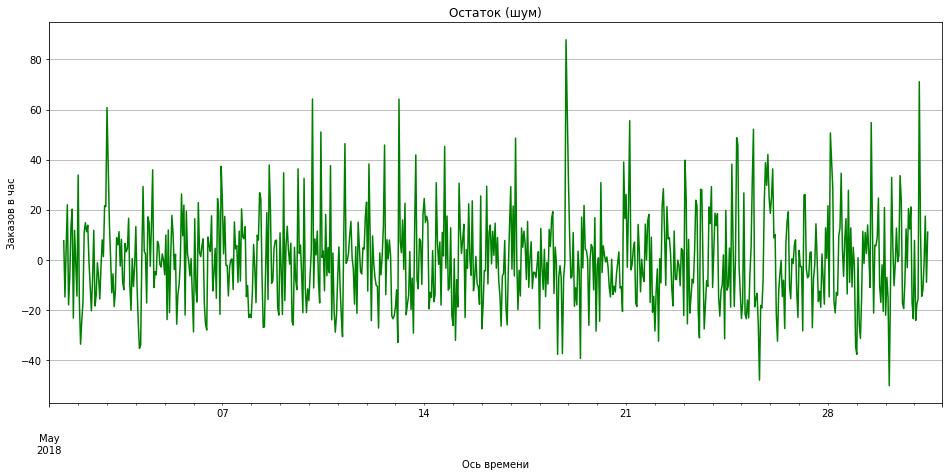

In [ ]:
# выделение трендов, сезонностей и шума (МАРТ)
df_month = df[df.index.month == 5]
decomposed_month = seasonal_decompose(df_month)

decomposed_month.trend.plot(figsize=(16,7), grid=True, color='green',
                            title='Тренды', xlabel='Ось времени', ylabel='Кол-во заказов в час')
plt.show()

decomposed_month.seasonal['2018-05-01':'2018-05-07'].plot(figsize=(16,7), grid=True, color='green',
                               title='Сезонности', xlabel='Ось времени', ylabel='Заказов в час')
plt.show()

decomposed_month.resid.plot(figsize=(16,7), grid=True, color='green',
                            title='Остаток (шум)', xlabel='Ось времени', ylabel='Заказов в час')
plt.show()

<a id='section_2A'></a>
### Создание признаков

Поскольку в исходных данных присутствует только одна колонка, которой недостаточно для точного предсказания, данные будут деконструированы и перезаписаны в отдельные колонки.
- Из _количества заказов_ будут выделены:
    - **отстающие признаки** - это количество заказов за несколько предыдущих часов*;
    - **скользящее среднее** - это среднее количество заказов за несколько ближайших часов*.
- Из _момента времени_ `2018-06-18 07:00:00` будут выделены **календарные** признаки:
    - месяц (Март - Август);
    - день месяца (1 - 31);
    - день недели (0 - 6 / "Понедельник" - "Воскресенье");
    - час (0 - 23).
    
*количество часов подбирается в зависимости от данных

Пояснения по выбранным факторам:

    1) Фактор год: НЕТ, однозначно не подходит. Данных собраны за один год. Поэтому будет просто константа.
    2) Фактор месяц: НУЖЕН, и ситуацию аналогично году, я назвать не могу. В истории присутствуют 6 месяцев, в каждом последующем чуть больше заказов. Знание месяца может задать "базу", грубый диапазон значений в пределах которых должно находиться предсказание.
    3) Фактор день: НЕТ (возможно), поскольку присутствует день недели, который куда более информативен.
    4) Фактор день недели: ДА, т.к. присутствует недельная сезонность.
    5) Фактор час: ДА, естественно.
    6) Факто lag: ДА, это параметр авторегрессии - учёт влияния вчерашних событий на сегодняшние.
    7) Фактор rolling: ДА, это аналог тренда. Чем больше окно сглаживания, тем ровнее линия тренда.
    8) Фактор std: НЕТ, при реальном использовании в бизнесе нет возможности узнать разброс среднего в будущем.

Ниже описана функция формирующая новые признаки.

In [ ]:
# функция создание признаков
def make_features(df, max_lag, window_size):
    
    # отстающие (предыдущие) признаки / lag features
    for lag in range (1, max_lag+1):
        df['num_orders_{}'.format(lag)] = df['num_orders'].shift(periods=lag, fill_value=df.iloc[-1, lag-1])
    
    # скользящее среднее / rolling mean
    df['rolling_mean'] = df['num_orders'].shift().rolling(window_size).mean()
    
    # календарные признаки / calendar features
    df['month']     = df.index.month
    df['dayofweek'] = df.index.dayofweek
    df['day']       = df.index.day
    df['hour']      = df.index.hour
    
    # удаление новообразованных пустых объектов
    df.dropna(inplace=True)

Значение метрики RMSE на тестовой выборке, с различными комбинациями признаков:
- 37.2 - без скользящего стандартного отклонения, lag=2, rolling_window_size=3
- 37.4 - без скользящего стандартного отклонения, lag=2, rolling_window_size=4
- 37.7 - без скользящего стандартного отклонения, lag=3
- 38.1 - со всеми признаками
- 40.8 - без дней
- 42.5 - без месяцев

___

<a id='section_3'></a>
## Обучение моделей

<a id='section_3A'></a>
### Валидация данных

Деление исходного датасета на 3 выборки под разные задачи:
- **Тренировочная** (80%) — на её объектах модель будет обучена;
- **Валидационная** (10%) — на её объектах модель будет контролироваться и корректироваться её обучение;
- **Тестовая** (10%) — на её объектах будет произведён итоговый тест для оценки качества модели.

Поскольку выборка относительно небольшая и увеличивать её - означает потеря актуальности, для подбора гиперпараметров моделей будет использована **кросс вылидация**, с сохранением временной последовательности.

In [ ]:
# выделение признаков
make_features(df, max_lag=2, window_size=3)
display(df.head())
target = df['num_orders']
features = df.drop(['num_orders'], axis=1)

# выделение тренировочной выборки
X_train, X_other, Y_train, Y_other = train_test_split(features,
                                                      target,
                                                      shuffle = False,
                                                      train_size = 0.80,
                                                      random_state = RANDOM_STATE)
# выделение валидационной и тестовой выборок
X_valid, X_test,  Y_valid, Y_test  = train_test_split(X_other,
                                                      Y_other,
                                                      shuffle = False,
                                                      test_size = 0.50,
                                                      random_state = RANDOM_STATE)

,num_orders,num_orders_1,num_orders_2,rolling_mean,month,dayofweek,day,hour
datetime,,,,,,,,
2018-03-01 03:00:00,66.0,71.0,85.0,93.333333,3,3,1,3
2018-03-01 04:00:00,43.0,66.0,71.0,74.000000,3,3,1,4
2018-03-01 05:00:00,6.0,43.0,66.0,60.000000,3,3,1,5
2018-03-01 06:00:00,12.0,6.0,43.0,38.333333,3,3,1,6
2018-03-01 07:00:00,15.0,12.0,6.0,20.333333,3,3,1,7


<a id='section_3B'></a>
### Масштабирование данных

Сформированные выборки необходимо подготовить к обучению, поскольку в текущем формате модель будет работать не корректно. **Численные данные** необходимо привести к единому масштабу, с помощью  техники `Standard Scaler`. Благодаря этому все признаки будут иметь одинаковую значимость.

In [ ]:
# масштабирование признаков
numeric = ['num_orders_1', 'num_orders_2']     

scaler = StandardScaler()
scaler.fit(X_train[numeric])
for features in [X_train, X_valid, X_test]:
    features[numeric] = scaler.transform(features[numeric])

display(X_train.head())

,num_orders_1,num_orders_2,rolling_mean,month,dayofweek,day,hour
datetime,,,,,,,
2018-03-01 03:00:00,-0.086800,0.314371,93.333333,3,3,1,3
2018-03-01 04:00:00,-0.229856,-0.086390,74.000000,3,3,1,4
2018-03-01 05:00:00,-0.887916,-0.229519,60.000000,3,3,1,5
2018-03-01 06:00:00,-1.946534,-0.887912,38.333333,3,3,1,6
2018-03-01 07:00:00,-1.774866,-1.947066,20.333333,3,3,1,7


<a id='section_3C'></a>
### Базовая модель (Dummy model)

Это простейшая "модель", которая делает константное или примитивное предсказание. Её роль заключается в том, чтобы получить ориентир для сравнения качества применяемых моделей: их оценка должна быть ниже, чем оценка базовой модели.

In [ ]:
# предсказать среднее
pred = np.ones(len(X_test)) * df['num_orders'].mean()
rmse = mean_squared_error(Y_test, pred) ** 0.5 
print('Значение метрики RMSE: {:.1f}'.format(rmse))

Значение метрики RMSE: 71.7


In [ ]:
# предсказать предыдущее значение
pred = Y_test.shift(fill_value = Y_train.iloc[-1])
rmse = mean_squared_error(Y_test, pred) ** 0.5 
print('Значение метрики RMSE: {:.1f}'.format(rmse))

Значение метрики RMSE: 49.8


<a id='section_3D'></a>
### Модель линейной регрессии (LR)

Если можно так выразится, то это достаточно примитивная модель предсказывания, что является её и слабой и сильной стороной. Она проста в настройке, и выделяется высоким быстродействием. Особенно, если данные закодированы с помощью техники _One Hot Encoding_. Но может давать не такой точный результат, по сравнению с более сложными моделями.

In [ ]:
%%time

model = LinearRegression()
model.fit(X_train, Y_train)
prediction = model.predict(X_valid)
rmse = np.sqrt(mean_squared_error(Y_valid, prediction))
print('Минимальное значение RMSE: {:.1f}'.format(rmse))

Минимальное значение RMSE: 37.0
Wall time: 17 ms


<a id='section_3E'></a>
### Модель случайного леса (RF)

Ансамбль (набор) моделей решающих деревьев. Преимущество заключается в том, что вместе модели ошибаются в среднем не так сильно как по отдельности. Из ключевых параметров _Случайного леса_: количество деревьев и их глубина.

In [ ]:
rfm = RandomForestRegressor(random_state=RANDOM_STATE)
param_set = {'max_depth':[1, 2, 3], 'n_estimators':[10, 20, 40, 80, 120]} # перечень параметров модели и интересующие значения
tscv = TimeSeriesSplit(n_splits=8)
gsearch = GridSearchCV(rfm, param_grid=param_set, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=tscv, verbose=1)
GS_result = gsearch.fit(X_train, Y_train)

rfm = rfm.set_params(**GS_result.best_params_)
rfm.fit(X_train, Y_train)
prediction = rfm.predict(X_valid)
rmse = np.sqrt(mean_squared_error(Y_valid, prediction))
print('Минимальное значение RMSE: {:.1f}'.format(rmse))

best_RFM = rfm.set_params(**GS_result.best_params_)

t = %timeit -n10 -r10 -o rfm.fit(X_train, Y_train)
t = %timeit -n10 -r10 -o prediction = rfm.predict(X_valid)

Fitting 8 folds for each of 15 candidates, totalling 120 fits
Минимальное значение RMSE: 39.1
95.5 ms ± 937 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)
6.17 ms ± 320 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


<a id='section_3F'></a>
### Модель градиентного бустинга LightGBM

Последовательно построенный ансамблю моделей, каждая из которых учитывает ошибку предыдущей, и уменьшает её.

In [ ]:
gbm = lgb.LGBMRegressor(random_state=RANDOM_STATE)
param_set = {'max_depth':[1, 2, 3], 'n_estimators':[10, 20, 40, 80, 120, 160]}
tscv = TimeSeriesSplit(n_splits=8)
gsearch = GridSearchCV(gbm, param_grid=param_set, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=tscv, verbose=1)
GS_result = gsearch.fit(X_train, Y_train)

gbm = gbm.set_params(**GS_result.best_params_)
gbm.fit(X_train, Y_train)
prediction = gbm.predict(X_valid)
rmse = np.sqrt(mean_squared_error(Y_valid, prediction))
print('Минимальное значение RMSE: {:.1f}'.format(rmse))

best_GBM = gbm.set_params(**GS_result.best_params_)

t = %timeit -n10 -r10 -o gbm.fit(X_train, Y_train)
t = %timeit -n10 -r10 -o prediction = gbm.predict(X_valid)

Fitting 8 folds for each of 18 candidates, totalling 144 fits
Минимальное значение RMSE: 28.6
74.1 ms ± 13.6 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)
The slowest run took 6.34 times longer than the fastest. This could mean that an intermediate result is being cached.
7.48 ms ± 7.38 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


**Сравнение:** Общее время работы моделей крайне мало, чтобы это могло иметь большое значение. Тем более в условиях поставленной задачи, где отсутствует об этом упоминание. Тем не менее я укажу это время в качестве справочной информации.
- **Линейная регрессия** - самая быстродейственная модель: обучение и предсказание 15 мс. Значение RMSE: **37.0**.
- **Случайный лес** - самая медлительная модель: обучение 180 мс., предсказания 6 мс. Самое большое значение метрики: **39.1**.
- **Градиентный бустинг** - золотая середина: обучение 80 мс., предсказания ~6 мс. Наименьшая RMSE: **28.6**.

*время обучения и предсказания могут отличаться в зависимости от устройства (ПК/сервера) на котором выполняются эти операции.

___

<a id='section_4'></a>
## Тестирование моделей

In [ ]:
# увеличение обучающей выборки за счёт объединения тренер. и валидацион. выборок (+ 20% объектов)
# (supp. - англ. supplemented, дополненный)
X_supp = pd.concat([X_train, X_valid], ignore_index=True)
Y_supp = pd.concat([Y_train, Y_valid], ignore_index=True)

In [ ]:
# ГРАДИЕНТНЫЙ БУСТИНГ

model = best_GBM
model.fit(X_supp, Y_supp)
prediction = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(Y_test, prediction))
print('Значение RMSE: {:.1f}'.format(rmse))
t = %timeit -n10 -r10 -o model.fit(X_supp, Y_supp)
t = %timeit -n10 -r10 -o prediction = model.predict(X_test)

Значение RMSE: 37.2
77.3 ms ± 12.5 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)
5.16 ms ± 1.06 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


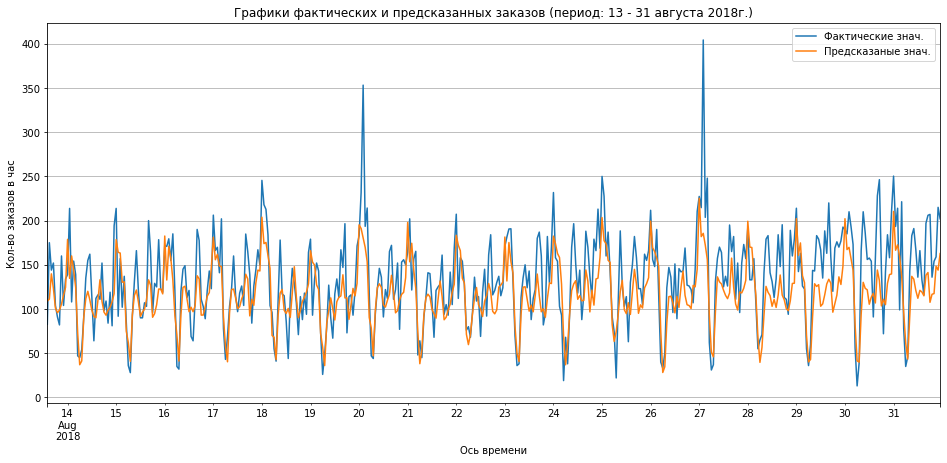

In [ ]:
# визуализация предсказаний
Y_test.rename('Фактические знач.').plot(figsize=(16, 7), legend=True, grid=True)
pd.Series(data=prediction, index=Y_test.index).rename('Предсказанные знач.').plot(figsize=(16, 7), legend=True, grid=True)
plt.title('Графики фактических и предсказанных заказов (период: 13 - 31 августа 2018г.)')
plt.ylabel('Кол-во заказов в час')
plt.xlabel('Ось времени');

<a id='section_4A'></a>
### ИТОГ

**Исходный датасет** был перегруппирован: новый _временной интервал 1 час_. Все объекты за этот период были объединены и заказы просуммированы. _Дубликаты_ и _пропуски данных_ - отсутствовали. _Хронологичный порядок_ соблюден в течение всего периода: 1 марта 2018 - 31 августа 2018. Имевшиеся _выбросы_ (~1%) были заменены на максимальное значение, в пределах нормального распределения.

**Анализ данных**. _Тренды_, помимо пульсаций, имеют прослеживаемый линейный рост. _Сезонность_ имеет одинаковую повторяемость: суточную, недельную и месячную, но в слабо выраженная. Это позволило определить перечень признаков и их размеры:
- сдвиг (количество заказов за 2 предыдущих часов);
- скользящее среднее (среднее количество заказов за 3 ближайших часа);
- месяц;
- день месяца;
- день недели;
- час.

Получившаяся выборка относительно небольшая и для подбора гиперпараметров моделей использовалась _кросс вылидация_, с учётом хронологического порядка. Были обучены три модели:
- _Линейная регрессия_ (Linear Regression);
- _Случайный лес_ (Random Forest Regressor);
- _Модель градиентный бустинг_ (Light GBM), которая показала лучшей. **Результат на тестовой выборке**: время обучение 84 мс. и предсказания 5 мс., RMSE: 37.2. Большую часть временного ряда получается предсказать, за исключение выбросов.

_Примечание_: Исходя из небольшого времени, требуемого для предсказания есть возможность снизить погрешность - уменьшив временной интервал, вернуться к исходному шагу в 10 минут. Данные, используемые в этом проекте, подойдут для этой задачи. К тому же следует уточнить первопричину появление выбросов. Это поможет понять как их обрабатывать и предсказывать.